# Employee Retention

* Goal 1: Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.
* Goal 2: What are the main factors that drive employee churn? Do they make sense? Explain your findings.
* Goal 3: If you could add to this data set just one variable that could help explain employee churn, what would that be?

## Table of Content

- Packages and Data
- 1 - Data Exploration
- 2 - Analysis and Discussion

## Packages and Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('employee_retention.csv', parse_dates=['join_date', 'quit_date'])
data['company_id'] = data['company_id'].astype(str)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  object        
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 1.3+ MB


## Data Exploration

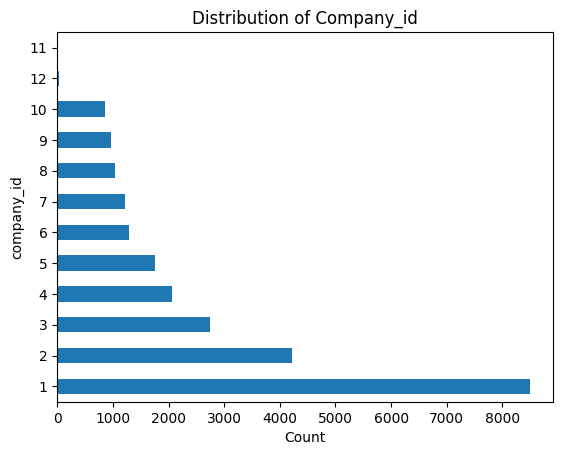

In [3]:
data['company_id'].value_counts().plot.barh()
plt.title('Distribution of Company_id')
plt.xlabel('Count')
plt.ylabel('company_id')
plt.show()

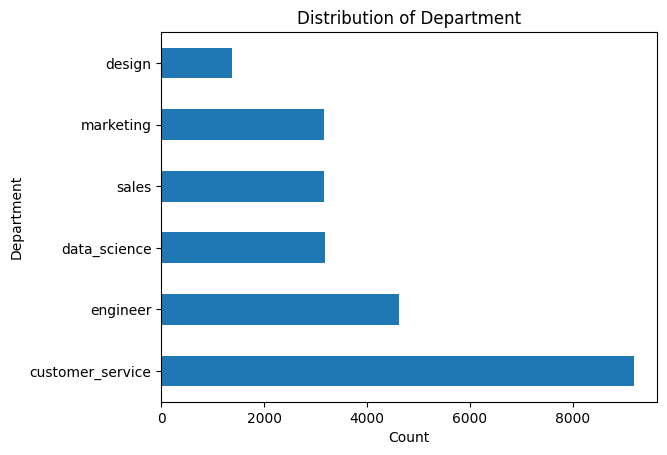

In [4]:
data['dept'].value_counts().plot.barh()
plt.title('Distribution of Department')
plt.xlabel('Count')
plt.ylabel('Department')
plt.show()

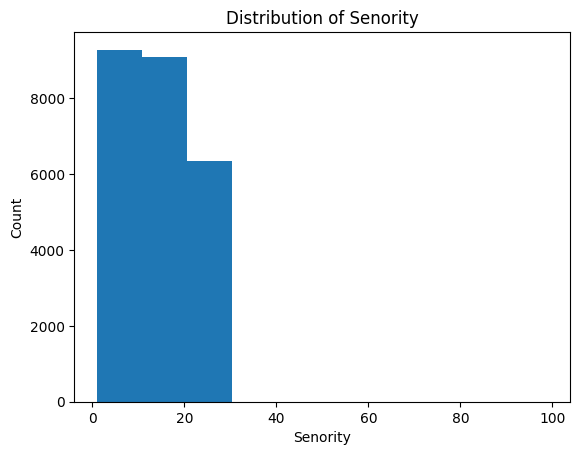

In [5]:
plt.hist(data['seniority'])
plt.title('Distribution of Senority')
plt.xlabel('Senority')
plt.ylabel('Count')
plt.show()

In [6]:
data.sort_values('seniority', ascending=False).head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09
11717,426218.0,2,customer_service,29,118000.0,2011-03-02,2013-07-12
12013,889253.0,2,engineer,29,318000.0,2011-09-12,NaT
647,664204.0,8,marketing,29,147000.0,2014-02-03,2015-02-20


發現有兩個觀察值的年資數值不正常，這邊選擇以中位數插補以保留其他欄位的資訊。

In [7]:
data.loc[data['seniority'] > 40, 'seniority'] = np.median(data['seniority'])

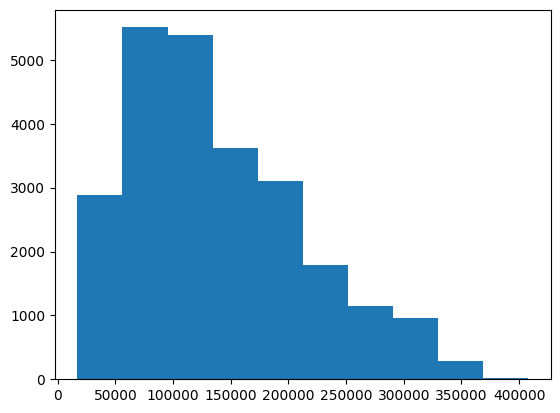

In [8]:
plt.hist(data['salary'])
plt.show()

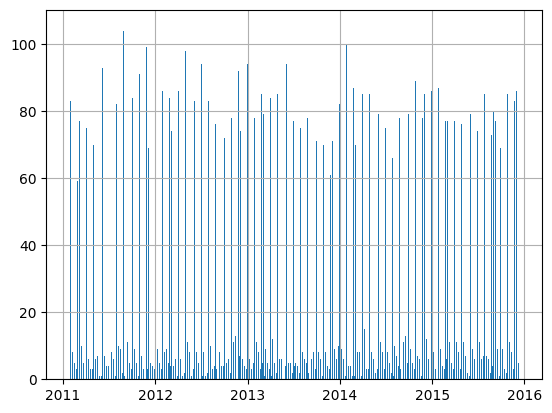

In [9]:
data['join_date'].hist(bins=pd.date_range(start='2011/01/24', end='2015/12/13').to_list())
plt.show()

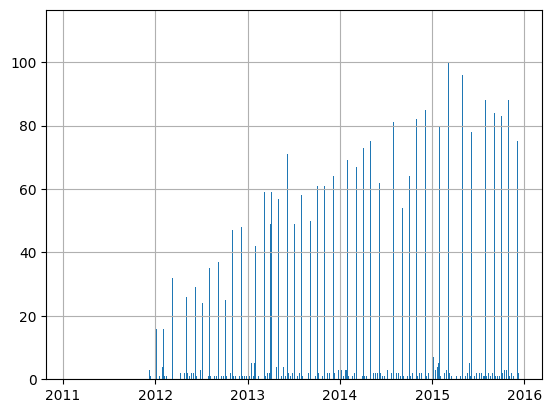

In [10]:
data['quit_date'].hist(bins=pd.date_range(start='2011/01/24',end='2015/12/13').to_list())
plt.show()

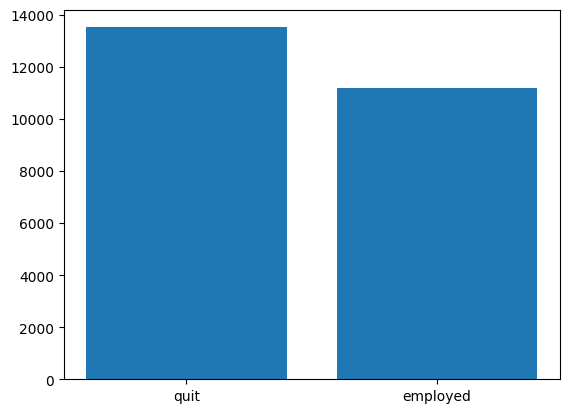

In [11]:
plt.bar(['quit', 'employed'], [data['quit_date'].notna().sum(), data['quit_date'].isna().sum()])
plt.show()

In [12]:
data['days'] = data['quit_date'] - data['join_date']
data.loc[data['quit_date'].isna(), 'days'] = pd.to_datetime('20151213', format='%Y%m%d') - data['join_date']
data['days'] = data['days'].dt.days
data['quit'] = data['quit_date'].notna().astype(int)
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,426,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,1
...,...,...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT,298,0
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT,48,0
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,780,1
24700,97289.0,10,engineer,14,266000.0,2011-12-13,2015-01-09,1123,1


## Analysis and Discussion

<AxesSubplot: xlabel='timeline'>

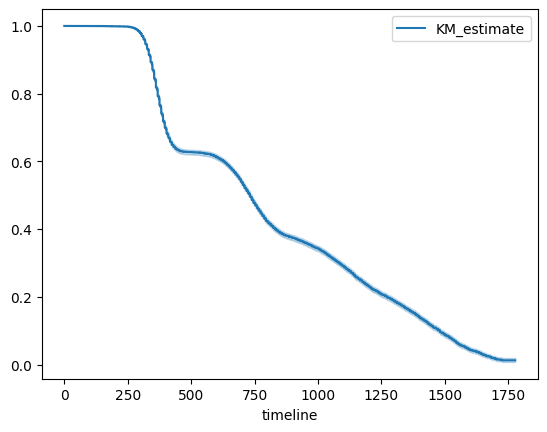

In [13]:
km = KaplanMeierFitter()
km.fit(data['days'], event_observed=data['quit'])
km.plot()

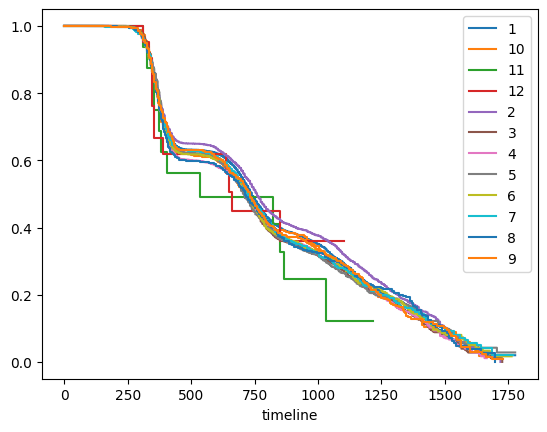

In [14]:
km = KaplanMeierFitter()
for i in sorted(data['company_id'].unique()):
    slice_data = data[data['company_id'] == i]
    km.fit(slice_data['days'], event_observed=slice_data['quit'], label=i)
    km.plot(ci_show=False)
plt.show()

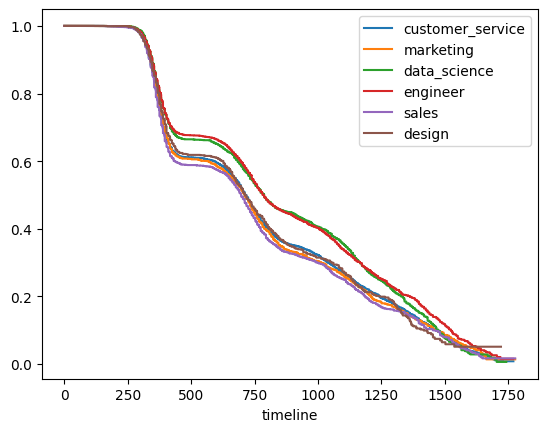

In [15]:
km = KaplanMeierFitter()
for i in data['dept'].unique():
    slice_data = data[data['dept'] == i]
    km.fit(slice_data['days'], event_observed=slice_data['quit'], label=i)
    km.plot(ci_show=False)
plt.show()

In [16]:
data_predictor = data[['dept', 'seniority', 'salary', 'days', 'quit']]
data_dummy = pd.get_dummies(data_predictor, drop_first=True)
data_dummy

,seniority,salary,days,quit,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,28,89000.0,585,1,0,0,0,0,0
1,20,183000.0,340,1,0,0,0,1,0
2,14,101000.0,426,0,0,0,0,1,0
3,20,115000.0,389,1,0,0,0,0,0
4,23,276000.0,1040,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
24697,16,97000.0,298,0,0,0,0,0,0
24698,10,160000.0,48,0,0,0,1,0,0
24699,11,67000.0,780,1,0,0,0,0,0
24700,14,266000.0,1123,1,0,0,1,0,0


In [17]:
data_dummy['seniority'] = MinMaxScaler().fit_transform(data_dummy[['seniority']]).flatten()
data_dummy['salary'] = MinMaxScaler().fit_transform(data_dummy[['salary']]).flatten()
data_dummy

,seniority,salary,days,quit,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,0.964286,0.184143,585,1,0,0,0,0,0
1,0.678571,0.424552,340,1,0,0,0,1,0
2,0.464286,0.214834,426,0,0,0,0,1,0
3,0.678571,0.250639,389,1,0,0,0,0,0
4,0.785714,0.662404,1040,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
24697,0.535714,0.204604,298,0,0,0,0,0,0
24698,0.321429,0.365729,48,0,0,0,1,0,0
24699,0.357143,0.127877,780,1,0,0,0,0,0
24700,0.464286,0.636829,1123,1,0,0,1,0,0


In [18]:
cox = CoxPHFitter()
cox.fit(data_dummy, 'days', event_col='quit')
print(cox.print_summary())

<lifelines.CoxPHFitter: fitted with 24702 total observations, 11192 right-censored observations>
             duration col = 'days'
                event col = 'quit'
      baseline estimation = breslow
   number of observations = 24702
number of events observed = 13510
   partial log-likelihood = -122180.28
         time fit was run = 2022-12-20 12:08:23 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
seniority           0.30       1.35       0.05             0.21             0.39                 1.23                 1.48
salary             -0.73       0.48       0.09            -0.91            -0.55                 0.40                 0.58
dept_data_science   0.06       1.06       0.04            -0.02             0.14                 0.98                 1.15
dept_design         0.09       1.10       0.04             0.01             0.17                 1.01                 1.19
dept_engineer       0.03       1.03       0.04            -0.04             0.11                 0.96                 1.11
dept_marketing      0.12       1.12       0.03             0.06             0.18                 1.06                 1.19
dept_sales          0.16       1.18       0.03             0.10             0.22                 1.11                 1.25

                    cmp to     z      p   -log2(p)
covariate                                         
seniority             0.00  6.51 <0.005      33.61
salary                0.00 -7.96 <0.005      49.03
dept_data_science     0.00  1.48   0.14       2.86
dept_design           0.00  2.26   0.02       5.39
dept_engineer         0.00  0.85   0.39       1.35
dept_marketing        0.00  3.83 <0.005      12.91
dept_sales            0.00  5.40 <0.005      23.87
---
Concordance = 0.53
Partial AIC = 244374.56
log-likelihood ratio test = 192.76 on 7 df
-log2(p) of ll-ratio test = 124.27

None


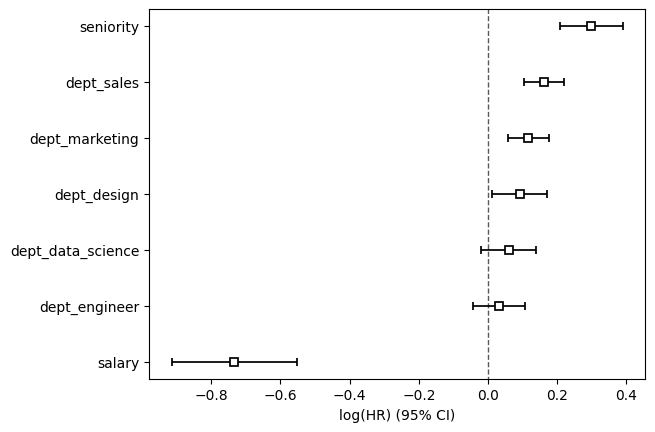

In [19]:
cox.plot()
plt.show()

In [35]:
data['predicted_days'] = np.round(cox.predict_expectation(data_dummy[['salary', 'seniority', 'dept_data_science', 'dept_design', 'dept_engineer', 'dept_marketing', 'dept_sales']]))
data['predicted_quit_date'] = data['join_date'] + pd.to_timedelta(data['predicted_days'], unit='D')
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days,quit,predicted_days,predicted_quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,1,735.0,2016-03-28
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,1,792.0,2015-06-30
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,426,0,757.0,2016-11-08
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,1,787.0,2014-07-10
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,1,873.0,2014-03-08
...,...,...,...,...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT,298,0,791.0,2017-04-19
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT,48,0,851.0,2018-02-23
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,780,1,790.0,2015-11-02
24700,97289.0,10,engineer,14,266000.0,2011-12-13,2015-01-09,1123,1,916.0,2014-06-16
